In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

In [3]:
train_x = np.linspace(0, 1, 100)
train_y = np.sin(train_x * (2 * np.pi)) + np.random.randn(train_x.size) * np.sqrt(0.04)

tensor_train_x = torch.tensor(train_x)
tensor_train_y = torch.tensor(train_y)

In [4]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [5]:

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(tensor_train_x, tensor_train_y, likelihood)

In [6]:
training_iter = 50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(tensor_train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, tensor_train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/50 - Loss: 0.937   lengthscale: 0.693   noise: 0.693
Iter 2/50 - Loss: 0.906   lengthscale: 0.644   noise: 0.644
Iter 3/50 - Loss: 0.873   lengthscale: 0.598   noise: 0.598
Iter 4/50 - Loss: 0.835   lengthscale: 0.555   noise: 0.554
Iter 5/50 - Loss: 0.794   lengthscale: 0.514   noise: 0.513
Iter 6/50 - Loss: 0.747   lengthscale: 0.475   noise: 0.474
Iter 7/50 - Loss: 0.698   lengthscale: 0.439   noise: 0.437
Iter 8/50 - Loss: 0.647   lengthscale: 0.404   noise: 0.402
Iter 9/50 - Loss: 0.600   lengthscale: 0.372   noise: 0.370
Iter 10/50 - Loss: 0.556   lengthscale: 0.342   noise: 0.339
Iter 11/50 - Loss: 0.516   lengthscale: 0.315   noise: 0.311
Iter 12/50 - Loss: 0.480   lengthscale: 0.292   noise: 0.284
Iter 13/50 - Loss: 0.446   lengthscale: 0.272   noise: 0.259
Iter 14/50 - Loss: 0.413   lengthscale: 0.256   noise: 0.237
Iter 15/50 - Loss: 0.381   lengthscale: 0.243   noise: 0.216
Iter 16/50 - Loss: 0.349   lengthscale: 0.233   noise: 0.197
Iter 17/50 - Loss: 0.318   length

In [7]:
test_x = np.linspace(0, 1, 51)
tensor_test_x = torch.tensor(test_x)

model.eval()
likelihood.eval()


f_preds = model(tensor_test_x)
y_preds = likelihood(model(tensor_test_x))

f_mean = f_preds.mean
f_var = f_preds.variance
f_covar = f_preds.covariance_matrix
f_samples = f_preds.sample(sample_shape=torch.Size((1000,)))

/home/users/delon/.local/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


In [8]:
import cProfile
cProfile.run('f_preds.mean')

         4 function calls in 0.000 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 <string>:1(<module>)
        1    0.000    0.000    0.000    0.000 multivariate_normal.py:194(mean)
        1    0.000    0.000    0.000    0.000 {built-in method builtins.exec}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}




In [9]:
model(tensor_test_x).__dict__

{'_islazy': True,
 'loc': tensor([ 0.0034,  0.1353,  0.2661,  0.3934,  0.5145,  0.6268,  0.7282,  0.8167,
          0.8906,  0.9485,  0.9895,  1.0131,  1.0191,  1.0077,  0.9795,  0.9352,
          0.8761,  0.8035,  0.7188,  0.6237,  0.5199,  0.4090,  0.2930,  0.1735,
          0.0524, -0.0687, -0.1881, -0.3041, -0.4151, -0.5196, -0.6160, -0.7030,
         -0.7794, -0.8438, -0.8955, -0.9335, -0.9573, -0.9665, -0.9612, -0.9415,
         -0.9080, -0.8614, -0.8030, -0.7341, -0.6562, -0.5711, -0.4808, -0.3873,
         -0.2925, -0.1984, -0.1068], dtype=torch.float64,
        grad_fn=<ViewBackward0>),
 '_covar': <linear_operator.operators.dense_linear_operator.DenseLinearOperator at 0x7f73fa6238b0>,
 '_MultivariateNormal__unbroadcasted_scale_tril': None,
 '_validate_args': False,
 '_batch_shape': torch.Size([]),
 '_event_shape': torch.Size([51])}

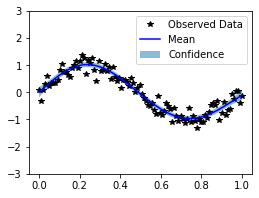

In [10]:
# Initialize plot
f, ax = plt.subplots(1, 1, figsize=(4, 3))
with torch.no_grad():
    # Get upper and lower confidence bounds
    lower, upper = f_preds.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x, train_y, 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x, f_preds.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x, lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])


In [11]:
model.covar_module.base_kernel.lengthscale

tensor([[0.2612]], grad_fn=<SoftplusBackward0>)

In [12]:
model.mean_module.constant

Parameter containing:
tensor(-0.1188, requires_grad=True)

In [13]:
model.state_dict()

OrderedDict([('likelihood.noise_covar.raw_noise', tensor([-3.1202])),
             ('likelihood.noise_covar.raw_noise_constraint.lower_bound',
              tensor(1.0000e-04)),
             ('likelihood.noise_covar.raw_noise_constraint.upper_bound',
              tensor(inf)),
             ('mean_module.raw_constant', tensor(-0.1188)),
             ('covar_module.raw_outputscale', tensor(0.5094)),
             ('covar_module.base_kernel.raw_lengthscale', tensor([[-1.2091]])),
             ('covar_module.base_kernel.raw_lengthscale_constraint.lower_bound',
              tensor(0.)),
             ('covar_module.base_kernel.raw_lengthscale_constraint.upper_bound',
              tensor(inf)),
             ('covar_module.raw_outputscale_constraint.lower_bound',
              tensor(0.)),
             ('covar_module.raw_outputscale_constraint.upper_bound',
              tensor(inf))])

In [14]:
np.atleast_2d([1,2,3])

array([[1, 2, 3]])

In [15]:
from scipy.spatial.distance import cdist

class numpy_ConstantMean():
    def __init__(self, raw_constant):
        self.constant = raw_constant
    def __call__(self, input):
        return self.constant * np.ones_like(input)
        
class numpy_ScaleKernel():
    def __init__(self, base_kernel, scale):
        self.base_kernel = base_kernel
        self.scale = scale
    
    def __call__(self, x1, x2 = None):
        if(x2 is None):
            x2 = x1
        return self.base_kernel(x1, x2)*self.scale

class numpy_RBFKernel():
    def __init__(self, lengthscale):
        self.lengthscale = lengthscale
        
    def __call__(self, x1, x2 = None):
        _x1 = x1 / self.lengthscale
        
        if(x2 is None):
            x2 = x1

        _x2 = x2 / self.lengthscale
        

        if(len(x1.shape) == 1): #handle 1d data
            _x1 = np.expand_dims(x1, axis=1) / self.lengthscale
            _x2 = np.expand_dims(x2, axis=1) / self.lengthscale
            
        distance_sq = np.square(cdist(_x1, _x2, 'minkowski', p=2))
        
        kernel = np.exp(-distance_sq / 2.0)
        
        return kernel


In [16]:
model.likelihood.noise_covar.noise.detach().numpy()[0]

0.043300934

In [17]:
model.state_dict()

OrderedDict([('likelihood.noise_covar.raw_noise', tensor([-3.1202])),
             ('likelihood.noise_covar.raw_noise_constraint.lower_bound',
              tensor(1.0000e-04)),
             ('likelihood.noise_covar.raw_noise_constraint.upper_bound',
              tensor(inf)),
             ('mean_module.raw_constant', tensor(-0.1188)),
             ('covar_module.raw_outputscale', tensor(0.5094)),
             ('covar_module.base_kernel.raw_lengthscale', tensor([[-1.2091]])),
             ('covar_module.base_kernel.raw_lengthscale_constraint.lower_bound',
              tensor(0.)),
             ('covar_module.base_kernel.raw_lengthscale_constraint.upper_bound',
              tensor(inf)),
             ('covar_module.raw_outputscale_constraint.lower_bound',
              tensor(0.)),
             ('covar_module.raw_outputscale_constraint.upper_bound',
              tensor(inf))])

In [18]:
model.mean_module.constant.detach().numpy()

array(-0.11876937, dtype=float32)

In [19]:
gpytorch_mean = model.mean_module(tensor_train_x)
tmp_mean_module = numpy_ConstantMean(model.mean_module.constant.detach().numpy())

np.allclose(gpytorch_mean.detach().numpy(), 
            tmp_mean_module(train_x) )

True

In [20]:
model.covar_module.base_kernel.lengthscale.detach().numpy()[0][0]

0.2611828

In [21]:
tmp_base_kernel = numpy_RBFKernel(model.covar_module.base_kernel.lengthscale.detach().numpy()[0,0])

In [22]:
gpytorch_base_oup = model.covar_module.base_kernel(tensor_train_x, tensor_test_x).to_dense().detach().numpy()
my_base_oup = tmp_base_kernel(train_x, test_x)

In [23]:
np.allclose(gpytorch_base_oup, my_base_oup)

True

In [24]:
tmp_covar_module = numpy_ScaleKernel(tmp_base_kernel, 
                                     model.covar_module.outputscale.detach().numpy())


In [25]:
gpytorch_cov_oup = model.covar_module(tensor_train_x, tensor_test_x).to_dense().detach().numpy()
my_cov_oup = tmp_covar_module(train_x, test_x)

In [26]:
np.allclose(gpytorch_cov_oup, my_cov_oup)

True

In [27]:
class numpy_MultivariateNormal():
    def __init__(self, mean, covariance_matrix):
        self.loc = mean
        self._covar = covariance_matrix
        
    def confidence_region(self):
        std2 = 2*np.sqrt(np.diag(self._covar))
        mean = self.mean
        return mean - std2, mean + std2
    
my_pred = numpy_MultivariateNormal(tmp_mean_module(test_x), tmp_covar_module(test_x))

In [28]:
import scipy

In [44]:
KXSX = tmp_covar_module(test_x, train_x)
KXSXS = tmp_covar_module(test_x, test_x)
KXXS = tmp_covar_module(train_x, test_x)
KXX = tmp_covar_module(train_x, train_x) + model.likelihood.noise_covar.noise.detach().numpy()[0] * np.eye(train_x.shape[0])
L = np.linalg.cholesky(KXX)

_y = train_y - tmp_mean_module(train_x)

alpha = scipy.linalg.solve_triangular(L.T, scipy.linalg.solve_triangular(L, _y, lower=True))

my_predictive_mean = np.einsum('ij,j->i', KXSX, alpha)+ tmp_mean_module(test_x)


beta = scipy.linalg.solve_triangular(L.T, scipy.linalg.solve_triangular(L, KXXS, lower=True))


my_predictive_cov = KXSXS - np.einsum('ij,jk->ik', KXSX, beta)

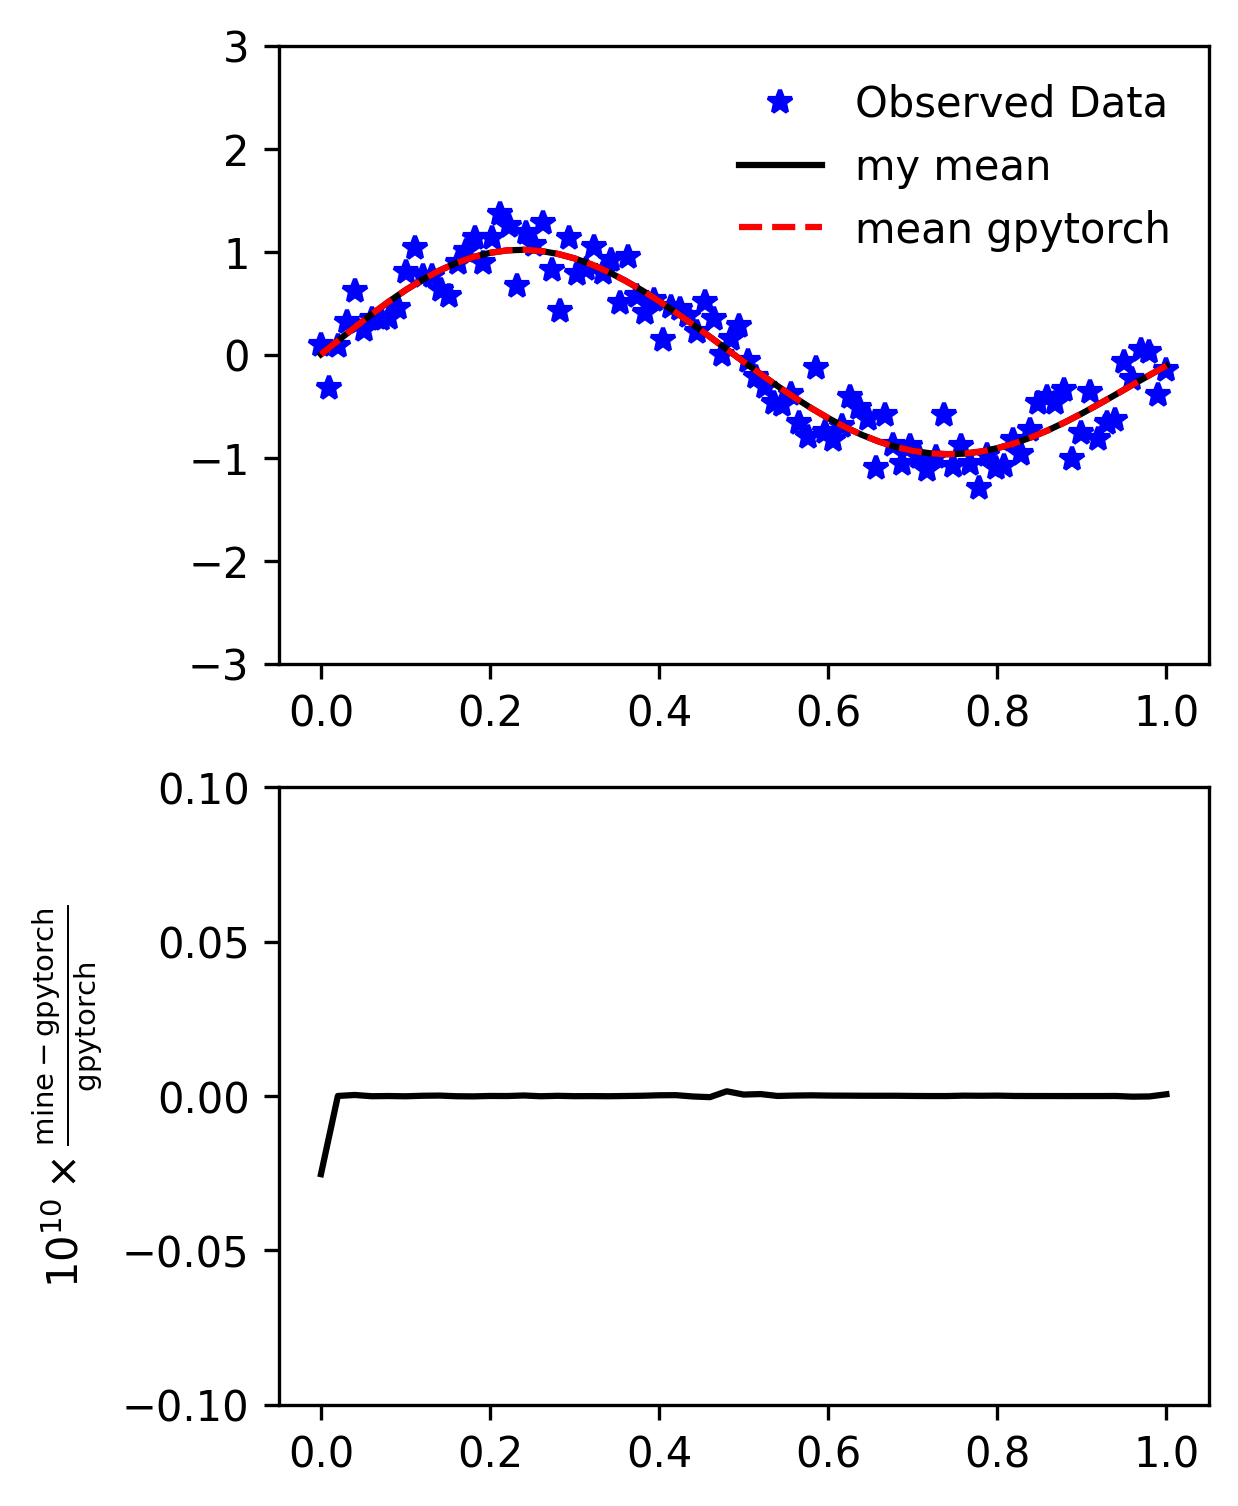

In [55]:
# Initialize plot
f, ax = plt.subplots(2, 1, figsize=(4, 6), dpi=300)

with torch.no_grad():

    # Plot training data as black stars
    ax[0].plot(train_x, train_y, 'b*')

    ax[0].plot(test_x, my_predictive_mean, 'k')
    ax[0].plot(test_x, f_preds.mean.numpy(), 'r--')

    ax[0].set_ylim([-3, 3])
    ax[0].legend(['Observed Data', 'my mean', 'mean gpytorch'], frameon=False)

    
    ax[1].plot(test_x, 1e10*(f_preds.mean.numpy()-my_predictive_mean)/f_preds.mean.numpy(), 'k')
    ax[1].set_ylabel(r'$10^{10}\times\frac{{\rm mine} - {\rm gpytorch}}{\rm gpytorch}$')
    ax[1].set_ylim(-1e-1, 1e-1)